In [2]:
import flow2graph
from pathlib import Path
import networkx as nx

In [3]:
path_csv = Path("./Datasets/CTU-13-Extended/52.csv.tgz")

ip_malicious = {'147.32.84.165', '147.32.84.191', '147.32.84.192'}
ip_normal = {'147.32.84.170', '147.32.84.134', '147.32.84.164', '147.32.87.36', '147.32.80.9', '147.32.87.11'}

In [305]:
dt = flow2graph.NetflowDataset(
        path_csv,
        chunksize=int(1e6),
        ip_malicious=ip_malicious,
        ip_normal=ip_normal
    )

In [306]:
import json
dt_features = dt.get_features()

print("raw dataset features:\n")
print(json.dumps(dt_features, indent=4, separators=(',', ': ')))

print()

total_flows = dt_features['malicious']['n_flows'] + dt_features['normal']['n_flows'] + dt_features['background']['n_flows']
print(f"ratio malicious : {dt_features['malicious']['n_flows']/total_flows:.3f}")
print(f"ratio normal    : {dt_features['normal']['n_flows']/total_flows:.3f}")
print(f"ratio background: {dt_features['background']['n_flows']/total_flows:.3f}")

7it [00:04,  1.52it/s]

raw dataset features:

{
    "malicious": {
        "n_nodes": 3,
        "n_flows": 2029977,
        "flows:": {
            "sum": 2135245838.0,
            "mean": 608.4135161333252,
            "mean_std": 7.91125930779223
        }
    },
    "normal": {
        "n_nodes": 6,
        "n_flows": 116466,
        "flows:": {
            "sum": 51657803.0,
            "mean": 367.91595040725036,
            "mean_std": 484.15594561633276
        }
    },
    "background": {
        "n_nodes": 41882,
        "n_flows": 4189408,
        "flows:": {
            "sum": 3200631276.0,
            "mean": 797.4265418408487,
            "mean_std": 681.5247272549544
        }
    }
}

ratio malicious : 0.320
ratio normal    : 0.018
ratio background: 0.661


In [307]:
print("Time window size:", dt._window_time_sec, "seconds")
g_malicious = []
for (i, (g, n_labels)) in enumerate(dt):
        print('---------------------')
        print("Graph", i)
        print(nx.classes.function.info(g))
        print('n_flow_background =', n_labels[flow2graph.Label.background.value])
        print('n_flow_normal     =', n_labels[flow2graph.Label.normal.value])
        print('n_flow_malicious  =', n_labels[flow2graph.Label.malicious.value])
        if n_labels[flow2graph.Label.malicious.value] > 0:
            g_malicious.append(g)
        print()
print(len(g_malicious))

Time window size: 60 seconds
---------------------
Graph 0
Name: 
Type: DiGraph
Number of nodes: 5532
Number of edges: 10992
Average in degree:   1.9870
Average out degree:   1.9870
n_flow_background = 975498
n_flow_normal     = 24502
n_flow_malicious  = 0

---------------------
Graph 1
Name: 
Type: DiGraph
Number of nodes: 5080
Number of edges: 10324
Average in degree:   2.0323
Average out degree:   2.0323
n_flow_background = 975498
n_flow_normal     = 24502
n_flow_malicious  = 0

---------------------
Graph 2
Name: 
Type: DiGraph
Number of nodes: 4660
Number of edges: 9531
Average in degree:   2.0453
Average out degree:   2.0453
n_flow_background = 975498
n_flow_normal     = 24502
n_flow_malicious  = 0

---------------------
Graph 3
Name: 
Type: DiGraph
Number of nodes: 5075
Number of edges: 10335
Average in degree:   2.0365
Average out degree:   2.0365
n_flow_background = 975498
n_flow_normal     = 24502
n_flow_malicious  = 0

---------------------
Graph 4
Name: 
Type: DiGraph
Numbe

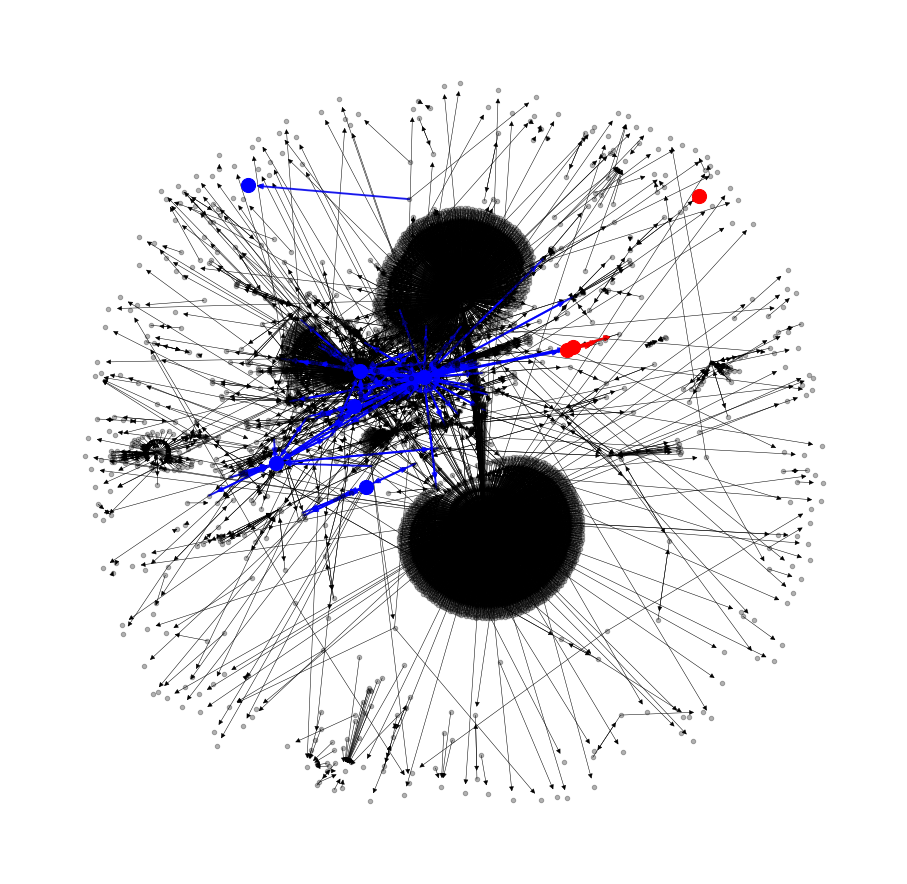

In [308]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,16))
flow2graph.plot_flow_graph(g_malicious[1], ip_malicious, ip_normal)

In [9]:
import torch
import dgl
import numpy as np

Using backend: pytorch


In [10]:
from multiprocessing import Pool
import itertools

def chunks(l, n):
    """Divide a list of nodes `l` in `n` chunks"""
    l_c = iter(l)
    while 1:
        x = tuple(itertools.islice(l_c, n))
        if not x:
            return
        yield x
        
def betweenness_centrality_parallel(G, processes=None):
    """Parallel betweenness centrality  function"""
    p = Pool(processes=processes)
    node_divisor = len(p._pool) * 4
    node_chunks = list(chunks(G.nodes(), int(G.order() / node_divisor)))
    num_chunks = len(node_chunks)
    bt_sc = p.starmap(
        nx.betweenness_centrality_subset,
        zip(
            [G] * num_chunks,
            node_chunks,
            [list(G)] * num_chunks,
            [True] * num_chunks,
            [None] * num_chunks,
        ),
    )

    # Reduce the partial solutions
    bt_c = bt_sc[0]
    for bt in bt_sc[1:]:
        for n in bt:
            bt_c[n] += bt[n]
    return bt_c

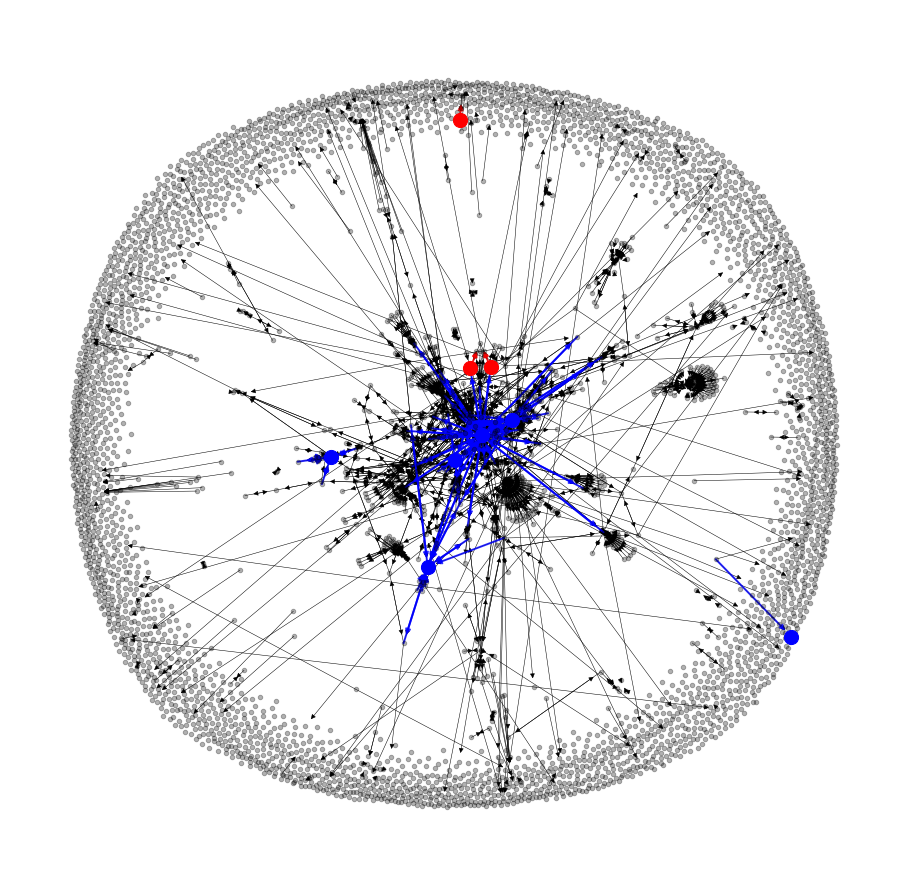

In [354]:
def remove_noise(g, k=3):
    bt = betweenness_centrality_parallel(g)
    bt = sorted(bt.items() , key=lambda x: x[-1])[::-1]
    g_copy = g.copy()
    g_copy.remove_nodes_from(map(lambda x: x[0], bt[:k]))
    return g_copy

plt.figure(figsize=(16,16))
flow2graph.plot_flow_graph(remove_noise(g_malicious[1]), ip_malicious, ip_normal)

In [12]:
# g_copy.remove_nodes_from()
g_copy.number_of_nodes(), g_malicious.number_of_nodes(), g_copy.number_of_edges(), g_malicious.number_of_edges()     

(2603, 2606, 1290, 5179)

In [355]:
def nx_to_dgl(g):
    g = dgl.from_networkx(g, node_attrs=['label'], edge_attrs=['features', 'label'])
    g.ndata['label'][(g.ndata['label'] == flow2graph.Label.background.value) \
                     | (g.ndata['label'] == flow2graph.Label.normal.value)] = 0
    g.ndata['label'][g.ndata['label'] == flow2graph.Label.malicious.value] = 1
    return g
dataset = list(map(nx_to_dgl, map(remove_noise, g_malicious)))

In [314]:
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F

class EdgeToNode(nn.Module):
    def __init__(self, in_features, out_features, non_linear=None):
        super().__init__()
        self.linear_in = nn.Linear(in_features, out_features)
        self.linear_out = nn.Linear(in_features, out_features)
        self.non_linear = non_linear or nn.Identity()
        
    def forward(self, graph: dgl.DGLGraph, h):
        h_in, h_out = self.linear_in(h), self.linear_out(h)
        h_in, h_out = self.non_linear(h_in), self.non_linear(h_out)
        
        with graph.local_scope():
            graph.edata['h'] = h_in + h_out
            graph.update_all(dgl.function.copy_e('h', 'm'), dgl.function.sum('m', 'ft'))
            return graph.ndata['ft']

class SAGE(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        self.conv1 = dglnn.SAGEConv(in_feats=in_feats, out_feats=hid_feats, aggregator_type='mean')
        self.conv2 = dglnn.SAGEConv(in_feats=hid_feats, out_feats=out_feats, aggregator_type='mean')

    def forward(self, graph, h):    
        h = F.relu(self.conv1(graph, h))
        h = self.conv2(graph, h)
        return h
    
class NodeToEdge(nn.Module):
    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(dgl.function.u_dot_v('h', 'h', 'score'))
            return graph.edata['score']

class EdgePredictor(nn.Module):
    def __init__(self, in_features_e, out_features_e=16, hid_features_n=32, out_features_n=16):
        super().__init__()
        
        self.e2n = EdgeToNode(in_features=in_features_e, out_features=out_features_e, non_linear=nn.ReLU())
        self.lin1 = nn.Linear(in_features=out_features_e, out_features=out_features_e)
        self.sage = SAGE(in_feats=out_features_e, hid_feats=hid_features_n, out_feats=out_features_n)
        self.lin2 = nn.Linear(in_features=out_features_n, out_features=out_features_n)
        self.n2e = NodeToEdge()
        
    def forward(self, graph, h):    
        h = self.e2n(graph, h)
        h = self.lin1(h)
        h = F.relu(h)
        h = self.sage(graph, h)
        h = F.relu(h)
        h = self.lin2(h)
        h = self.n2e(graph, h)
#         h = (h - h.min()) / (h.max() - h.min())
        h = torch.sigmoid(h)
#         h = F.relu(h)
        
        return h

In [ ]:
from tqdm.notebook import tqdm
model = EdgePredictor(5)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

progress_bar = tqdm(range(200))

for epoch in progress_bar:
    for g in dataset:
        edge_label = g.edata['label'].float()
        edge_features = g.edata['features']
        for _ in range(10):
            pred = model(g, edge_features).squeeze()
            loss = criterion(pred, edge_label)
            progress_bar.set_description(f"loss: {loss.item():.3f}")
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    

In [422]:
# criterion(, dataset[0].edata['label'].float())
idx=4
pred = model(dataset[idx], dataset[idx].edata['features'])
a=set((pred>0.5).nonzero(as_tuple=True)[0].numpy())
b=set(dataset[idx].edata['label'].nonzero(as_tuple=True)[0].numpy())
len(a^b)/dataset[idx].num_edges(), len(a&b)/len(b)

(0.2135791366906475, 0.5297619047619048)

In [384]:
criterion

{'training': True,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict([('weight', None)]),
 '_non_persistent_buffers_set': set(),
 '_backward_hooks': OrderedDict(),
 '_forward_hooks': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_modules': OrderedDict(),
 'reduction': 'mean'}

In [ ]:
def evaluate(model, graph, features, labels, mask):
    model.eval()
    with th.no_grad():
        logits = model(graph, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = th.max(logits, dim=1)
        correct = th.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

In [ ]:
model = SAGE(in_feats=n_features, hid_feats=100, out_feats=n_labels)
opt = th.optim.Adam(model.parameters())

In [ ]:
from tqdm.notebook import tqdm
model.train()
t = tqdm(range(10))
for epoch in t:
    logits = model(graph, node_features)
    loss = F.cross_entropy(logits[train_mask], node_labels[train_mask])
    acc = evaluate(model, graph, node_features, node_labels, valid_mask)
    opt.zero_grad()
    loss.backward()
    opt.step()
    t.set_description(f"val_acc: {acc:0.3f}, loss: {loss.item():0.3f}")

In [ ]:
evaluate(model, graph, node_features, node_labels, valid_mask)

In [ ]:
class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.linear(in_features * 2, out_classes)
    def apply_edges(self, edges):    
        h_u = edges.src['h']
        h_v = edges.dst['h']
        score = self.W(th.cat([h_u, h_v], 1))
        return {'score': score}
    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [ ]:
class Model(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super().__init__()
        self.sage = SAGE(in_features, hidden_features, out_features)
        self.pred = DotProductPredictor()
    def forward(self, g, x):
        h = self.sage(g, x)
        h = self.pred(g, h)
        h = th.sigmoid(h)
        return h

In [ ]:
src = np.random.randint(0, 100, 500)
dst = np.random.randint(0, 100, 500)
# make it symmetric
edge_pred_graph = dgl.graph((np.concatenate([src, dst]), np.concatenate([dst, src])))
# synthetic node and edge features, as well as edge labels
edge_pred_graph.ndata['feature'] = th.randn(100, 10)
edge_pred_graph.edata['feature'] = th.randn(1000, 10)
edge_pred_graph.edata['label'] = th.randn(1000)
# synthetic train-validation-test splits
edge_pred_graph.edata['train_mask'] = th.zeros(1000, dtype=th.bool).bernoulli(0.6)

In [ ]:
node_features = edge_pred_graph.ndata['feature']
edge_label = edge_pred_graph.edata['label']
train_mask = edge_pred_graph.edata['train_mask']
model = Model(10, 32, 16)
opt = th.optim.Adam(model.parameters())
t = tqdm(range(100))
for epoch in t:
    pred = model(edge_pred_graph, node_features)
    loss = ((pred[train_mask] - edge_label[train_mask]) ** 2).mean()
    opt.zero_grad()
    loss.backward()
    opt.step()
    t.set_description(f"loss: {loss.item():.03f}")